In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

q_avg=np.empty((0,1))
Crate_idx=[2,5,6,7,8,9,12,13,14]
tempdata1=np.empty((0,578))
tempdata2=np.empty((0,578))
tempdata=np.empty((0,578))

for i in Crate_idx:
    dataPath=f'./dataset{i}'
    load_data=np.load(dataPath+'/cell.npz')
    Temp=load_data['temperature']
    q_lenth=len(Temp)-1
    Qg=np.loadtxt(dataPath+'/q_avg.txt')[:q_lenth]
    q_avg=np.concatenate((q_avg,Qg.reshape(-1,1)))
    tempdata1=np.concatenate((tempdata1,Temp[0:-1]),axis=0)
    tempdata2=np.concatenate((tempdata2,Temp[1:]),axis=0)
    # print(q_lenth)
    # tempdata=np.concatenate((tempdata,min_max_normalize_3d(Temp[0:-1])),axis=0)

def minmax_normalize(data, min_val=None, max_val=None):
    data = np.asarray(data)
    if min_val is None:
        min_val = np.min(data)
    if max_val is None:
        max_val = np.max(data)

    if max_val == min_val:
        return np.zeros_like(data)
    
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data,[min_val, max_val]

def minmax_denormalize(normalized_data, min_val, max_val):
    normalized_data = np.asarray(normalized_data)
    denormalized_data = normalized_data * (max_val - min_val) + min_val
    return denormalized_data

import matplotlib.pyplot as plt
from scipy.interpolate import SmoothBivariateSpline

Position=load_data['position']
x=np.linspace(0,0.009,40)
y=np.linspace(0,0.017997,40)
yy,xx=np.meshgrid(y,x)

ymatrix=[]
xflatten=[]

for i in range(len(tempdata2)):
    f_interp=SmoothBivariateSpline(Position[0],Position[1],tempdata2[i])
    ymatrix.append(f_interp.ev(yy,xx).transpose())
    f_interp=SmoothBivariateSpline(Position[0],Position[1],tempdata1[i])
    x4040=f_interp.ev(yy,xx).transpose()
    xflatten.append(x4040.flatten()[np.linspace(0,1599,400,dtype=int)])



In [2]:
xflatten=np.array(xflatten).astype(np.float32)
xscaler=MinMaxScaler(feature_range=(0,1))
xflatten=np.concatenate((q_avg,xflatten),axis=1).astype(np.float32)
xdata=xscaler.fit_transform(xflatten)

ymatrix=np.array(ymatrix).astype(np.float32)
ymin=np.min(ymatrix,axis=(1,2))
ymax=np.max(ymatrix,axis=(1,2))
ydata=np.concatenate((ymin.reshape(-1,1),ymax.reshape(-1,1)),axis=1)
yscaler=MinMaxScaler(feature_range=(0,1))
ydata=yscaler.fit_transform(ydata)

xdata.shape,ydata.shape

((32568, 401), (32568, 2))

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1=nn.Linear(401,1024)
        self.fc2=nn.Linear(1024,512)
        self.fc3=nn.Linear(512,2)
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

from torch.utils.data import Dataset,DataLoader
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx],self.y[idx]

dataset=MyDataset(xdata,ydata)
dataloader=DataLoader(dataset,batch_size=64,shuffle=True)



100%|██████████| 2000/2000 [1:05:22<00:00,  1.96s/it]


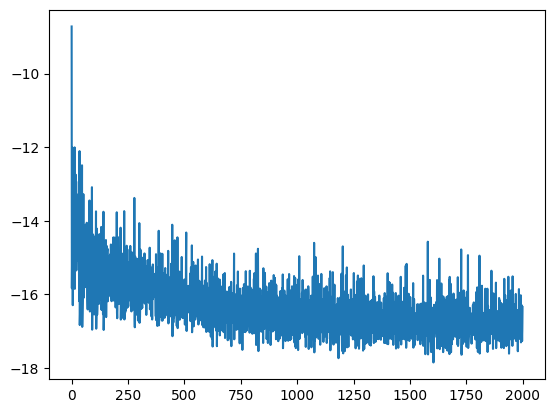

In [4]:
model=MLP().to(device)
from tqdm import tqdm
import os

lrate=0.0001
n_epochs=2000
optim=torch.optim.Adam(model.parameters(),lr=lrate)
criterion=nn.MSELoss()

tlosslist=[]

if os.path.isfile('MLP20250609'):
    model.load_state_dict(torch.load('MLP20250609'))
    print('load model')
else:
    for epoch in tqdm(range(n_epochs)):
        model.train()
        tlosses=0.0
        # optim.param_groups[0]['lr']=lrate*(1-epoch/n_epochs)
        for x,y in dataloader:
            x=x.to(device)
            y=y.to(device)
            optim.zero_grad()
            y_pred=model(x)
            tloss=criterion(y_pred,y)
            tloss.backward()
            optim.step()
            tlosses+=tloss.item()        
        tlosslist.append(tlosses/len(dataloader))
plt.plot(np.log(tlosslist))

In [5]:
torch.save(model.state_dict(),'MLP20250609')